## NIH CheXpert dataset (Classification)

## Import Library

In [1]:
import csv
import numpy as np
from pathlib import Path

# Plot 
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

#import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras import regularizers, optimizers
from keras import backend as K

# model 
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.models import load_model

# metric
from sklearn.metrics import classification_report


Using TensorFlow backend.


## Load data and calculate its counts 

In [2]:
DatasetPath = "D:/Dataset/CheXpert-v1.0-small"
csvPath     = "D:/Dataset/CheXpert-v1.0-small/train.csv"

positive_pos = 7 # 15: Pleural Effusion 
negatvie_pos = 5  # 5: No finding,

data = []
error = 0 
with open(csvPath, newline='') as f:
    rows = csv.reader(f)
    
    row = next(rows)
    title = [row[x] for x in np.asarray([negatvie_pos,positive_pos])]

    for line in rows:
        image_name = line[0]
        AP_L       = line[3]
        device       = line[18]

        if(device):
            if(float(device) == 0):
                if(line[positive_pos]):
                    positive_label = float(line[positive_pos])
                    if(positive_label == -1):
                        positive_label = 1
                    positive_label = int(positive_label)
                else:
                    positive_label = 0

                if(line[negatvie_pos]):
                    negative_label = float(line[negatvie_pos])
                    if(negative_label == -1):
                        negative_label = 1
                    negative_label = int(negative_label)
                else:
                    negative_label = 0

                if(positive_label == 1 and negative_label == 0):
                    data.append((image_name,AP_L,1))
                elif(positive_label == 0 and negative_label == 1):
                    data.append((image_name,AP_L,0))
                else:
                    continue

data = pd.DataFrame(data, columns=['filename', 'AP_L', 'label'] ,index=None)
data = data[~data[data.columns[1]].str.contains("Lateral")]
print(data['label'].value_counts())
data.head()

0    553
1    549
Name: label, dtype: int64


,filename,AP_L,label
0,CheXpert-v1.0-small/train/patient00019/study4/...,Frontal,1
1,CheXpert-v1.0-small/train/patient00084/study2/...,Frontal,0
3,CheXpert-v1.0-small/train/patient00204/study16...,Frontal,0
4,CheXpert-v1.0-small/train/patient00216/study1/...,Frontal,0
5,CheXpert-v1.0-small/train/patient00277/study13...,Frontal,0


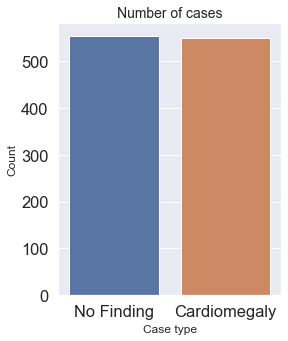

In [3]:
import seaborn as sns
# Get the counts for each class
cases_count = data['label'].value_counts()


# Plot the results 
plt.figure(figsize=(4,5))
sns.set(font_scale=1.5) # for label size
sns.barplot(x = cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(cases_count.index, [title[i] for i in cases_count.index])
plt.show()


In [10]:
#matplotlib.use("Agg")
from keras.utils import normalize
import cv2 as cv

msk = np.random.rand(len(data)) < 0.8
train_data = data[msk]
val_data = data[~msk]
# data generation for Keras
train_datagen=ImageDataGenerator()#rescale = 1./255,
                                 #featurewise_center=True,
                                 #featurewise_std_normalization=True,
                                 #rotation_range=5,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 #horizontal_flip=True)

target_size = (224,224)

rootPath = "D:/Dataset"
batch = 32
train_generator=train_datagen.flow_from_dataframe(dataframe=train_data, directory=rootPath , x_col="filename", y_col="label", class_mode="raw", target_size=target_size,  batch_size=batch)
val_generator=train_datagen.flow_from_dataframe(dataframe=val_data, directory=rootPath , x_col="filename", y_col="label", class_mode="raw", target_size=target_size,  batch_size=batch)



Found 874 validated image filenames.
Found 228 validated image filenames.


### #model architecture design/selection
# create the base pre-trained model



base_model = DenseNet121(input_shape=(224,224,3),include_top = False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
# add a global spatial average pooling layer

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(16, activation='relu')(x)
# and a logistic layer --  we have 5 classes
predictions = Dense(1, activation='sigmoid')(x)

#print(predictions)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional DenseNet layers


# compile the model (should be done *after* setting layers to non-trainable)



In [11]:
from keras.layers import Input,Convolution2D,BatchNormalization,Activation,MaxPooling2D
model_input = Input(shape=(224,224,3))
x = Convolution2D(filters = 16, kernel_size = (5,5), strides = 2, padding='same', 
                            data_format = 'channels_last')(model_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides = 2, padding ='same')(x)

x = Convolution2D(filters = 32, kernel_size = (5,5), strides = 1, padding='same', 
                            data_format = 'channels_last')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides = 2, padding ='same')(x)

x = Convolution2D(filters = 64, kernel_size = (5,5), strides = 1, padding='same', 
                            data_format = 'channels_last')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides = 2, padding ='same')(x)

x = Convolution2D(filters = 128, kernel_size = (5,5), strides = 1, padding='same', 
                            data_format = 'channels_last')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides = 2, padding ='same')(x)

x = Convolution2D(filters = 256, kernel_size = (5,5), strides = 1, padding='same', 
                            data_format = 'channels_last')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides = 2, padding ='same')(x)

x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(32, activation='relu')(x)
# and a logistic layer --  we have 5 classes
predictions = Dense(1, activation='sigmoid')(x)

#print(predictions)
model = Model(inputs=model_input, outputs=predictions)
model.summary()
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional DenseNet layers


# compile the model (should be done *after* setting layers to non-trainable)

# model training
adam = optimizers.Adam(lr=0.005,decay=0.1)
#SGD  = optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['binary_accuracy'])


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 16)      1216      
_________________________________________________________________
batch_normalization_6 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
activation_6 (Activation)    (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 32)        12832     
_________________________________________________________________
batch_normalization_7 (Batch (None, 56, 56, 32)        128 

In [6]:
from sklearn.utils.class_weight import compute_class_weight

weight = compute_class_weight('balanced', [0,1], data['label'].values)
print(weight)

[0.99638336 1.00364299]


D:\anaconda\envs\envmarquez\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0, 1], y=[1 0 0 ... 0 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [12]:
# model training
adam = optimizers.Adam(lr=0.0001,decay=0.1)
#SGD  = optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [13]:
# fit model
epochs  = 20
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n / train_generator.batch_size * 2,
                    validation_data=val_generator,
                    validation_steps=val_generator.n / val_generator.batch_size,
                    class_weight = weight,

                    epochs=epochs)


Epoch 1/20
55/54 [==============================] - 6s 107ms/step - loss: 0.6064 - binary_accuracy: 0.6696 - val_loss: 0.7104 - val_binary_accuracy: 0.5877
Epoch 2/20
55/54 [==============================] - 5s 96ms/step - loss: 0.5080 - binary_accuracy: 0.7739 - val_loss: 0.6883 - val_binary_accuracy: 0.6842
Epoch 3/20
55/54 [==============================] - 5s 93ms/step - loss: 0.4889 - binary_accuracy: 0.7914 - val_loss: 0.7551 - val_binary_accuracy: 0.7281
Epoch 4/20
55/54 [==============================] - 5s 99ms/step - loss: 0.4680 - binary_accuracy: 0.8044 - val_loss: 0.6099 - val_binary_accuracy: 0.7632
Epoch 5/20
55/54 [==============================] - ETA: 0s - loss: 0.4510 - binary_accuracy: 0.821 - 5s 97ms/step - loss: 0.4498 - binary_accuracy: 0.8211 - val_loss: 0.8414 - val_binary_accuracy: 0.7675
Epoch 6/20
55/54 [==============================] - 5s 94ms/step - loss: 0.4455 - binary_accuracy: 0.8275 - val_loss: 0.5263 - val_binary_accuracy: 0.7456
Epoch 7/20
55/54 [=

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


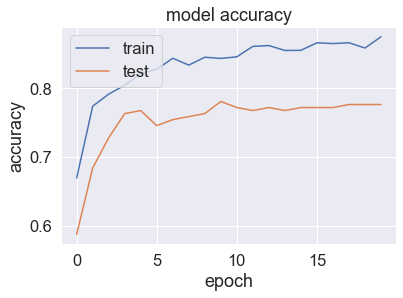

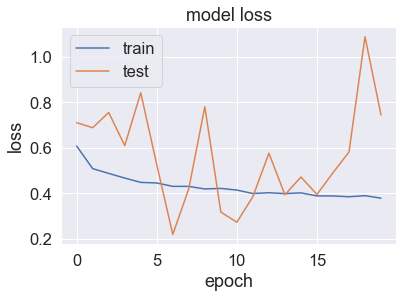

In [14]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()
# summarize history for loss 
plt.figure()
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [15]:
testcsvPath = "D:/Dataset/CheXpert-v1.0-small/valid.csv"

#positive_pos = 15 # 15: Pleural Effusion 
#negatvie_pos = 5  # 5: No finding,

test_data = []
with open(testcsvPath, newline='') as f:
    rows = csv.reader(f)
    
    row = next(rows)
    title = [row[x] for x in np.asarray([negatvie_pos,positive_pos])]

    for line in rows:
        image_name = line[0]
        AP_L       = line[3]
        device       = line[18]
        if(device):
            if(float(device) == 0):
                if(line[positive_pos]):
                    positive_label = float(line[positive_pos])
                    if(positive_label == -1):
                        positive_label = 1
                    positive_label = int(positive_label)
                else:
                    positive_label = 0

                if(line[negatvie_pos]):
                    negative_label = float(line[negatvie_pos])
                    if(negative_label == -1):
                        negative_label = 1
                    negative_label = int(negative_label)
                else:
                    negative_label = 0

                if(positive_label == 1 and negative_label == 0):
                    test_data.append((image_name,AP_L,1))
                elif(positive_label == 0 and negative_label == 1):
                    test_data.append((image_name,AP_L,0))
                else:
                    continue

test_data = pd.DataFrame(test_data, columns=['filename', 'AP_L', 'label'] ,index=None)
test_data = test_data[~test_data[test_data.columns[1]].str.contains("Lateral")]
print(test_data['label'].value_counts())
test_data.head()

1    32
0    26
Name: label, dtype: int64


,filename,AP_L,label
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Frontal,1
1,CheXpert-v1.0-small/valid/patient64544/study1/...,Frontal,0
2,CheXpert-v1.0-small/valid/patient64548/study1/...,Frontal,1
3,CheXpert-v1.0-small/valid/patient64551/study1/...,Frontal,0
5,CheXpert-v1.0-small/valid/patient64552/study1/...,Frontal,1


In [16]:
test_datagen=ImageDataGenerator( )#rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(dataframe=test_data, directory=rootPath , x_col="filename", y_col="label", class_mode="raw", target_size=target_size,  batch_size=1,shuffle = False)

test_generator.reset()
y_pred_keras = model.predict_generator(test_generator,verbose = 1,steps=test_generator.n)

Found 58 validated image filenames.
58/58 [==============================] - 0s 8ms/step


In [17]:
y_labels = test_generator.labels
#test = y_labels[:,np.newaxis]
test = y_labels[:,np.newaxis]
test = np.append(test,y_pred_keras,axis=1)

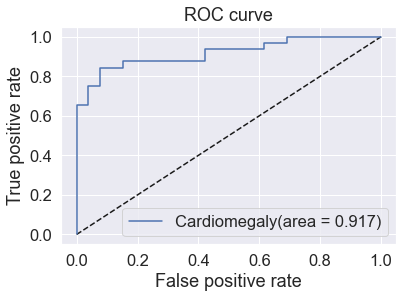

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_labels, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label= title[1] + '(area = {:.3f})'.format(auc_keras))
    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


<AxesSubplot:>

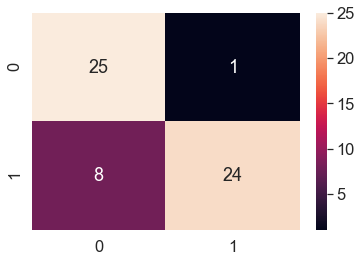

In [19]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_labels, y_pred_keras > 0.5, labels=None)

sns.heatmap(cf_matrix, annot=True)